# Preparing working environnment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import dataset
data = pd.read_csv('/content/drive/My Drive/DS_projet6/flipkart_com-ecommerce_sample_1050.csv')
data = data[['uniq_id', 'product_category_tree', 'image']]

# Retrieving categories
df_categ = data['product_category_tree'].str.split(pat = '>>', expand = True)
df_categ[0] = df_categ[0].apply(lambda x: str(x)[2:] if str(x)[:2] == '["' else x)

for c in np.arange(0,7,1):
    df_categ[c] = df_categ[c].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '"]' else x)
    
data = data.join(df_categ.iloc[:,:2])
data.rename(columns = {0 : 'category', 1 : 'subcategory'}, inplace = True)
data.drop(columns = 'product_category_tree', inplace = True)

# CNN on Black & White images

### Data preprocessing

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

save_path = '/content/drive/My Drive/DS_projet6/Edited_Images_NB/'

# Creating image collection
for i in range(len(data)):
    img = load_img(save_path + data['image'][i], target_size=(300, 300))
    img = img_to_array(img)
    
    if i == 0:
        img_collec = img
    else:
        img_collec = np.append(img_collec, img)

img_collec = img_collec.reshape((len(data), 300, 300, 3))

In [ ]:
# Train - test split
from sklearn.model_selection import train_test_split

y_ = pd.get_dummies(data['category'])
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(
    img_collec, y_, 
    test_size = 0.35,
    random_state = 143)

### Creating model

In [ ]:
# Creating a new model
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
from keras import optimizers

# Retrieving VGG16 model without fully-connected layers
model = VGG16(weights="imagenet", 
              include_top=False, 
              input_shape=(300, 300, 3))
model.trainable = False

# Adding new fully-connected layers
x = model.output
x = Flatten()(x)
#x = Dense(300, activation = 'relu')(x)
x = Dense(200, activation = 'relu')(x)
x = Dense(100, activation = 'relu')(x)

# Predicting with 7 classes
pred = Dense(7, activation = 'softmax')(x)
new_model = Model(inputs=model.input, outputs=pred)
    
# Compiling
new_model.compile(loss="categorical_crossentropy", 
                  optimizer='adam', 
                  metrics=["accuracy"])

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
# Training model
new_model.fit(X_train_nb, y_train_nb, 
              batch_size = 100, 
              epochs = 20, 
              validation_split = 0.2)

Epoch 1/20
6/6 [==============================] - 11s 2s/step - loss: 35.5981 - accuracy: 0.3912 - val_loss: 21.6031 - val_accuracy: 0.5034
Epoch 2/20
6/6 [==============================] - 5s 766ms/step - loss: 6.9072 - accuracy: 0.7738 - val_loss: 7.2949 - val_accuracy: 0.7143
Epoch 3/20
6/6 [==============================] - 5s 775ms/step - loss: 3.0018 - accuracy: 0.8929 - val_loss: 6.0972 - val_accuracy: 0.8027
Epoch 4/20
6/6 [==============================] - 5s 785ms/step - loss: 0.2361 - accuracy: 0.9779 - val_loss: 12.8056 - val_accuracy: 0.7551
Epoch 5/20
6/6 [==============================] - 5s 781ms/step - loss: 0.3838 - accuracy: 0.9728 - val_loss: 13.1637 - val_accuracy: 0.7755
Epoch 6/20
6/6 [==============================] - 5s 788ms/step - loss: 0.0364 - accuracy: 0.9949 - val_loss: 10.2618 - val_accuracy: 0.7959
Epoch 7/20
6/6 [==============================] - 5s 803ms/step - loss: 0.0191 - accuracy: 0.9949 - val_loss: 8.7197 - val_accuracy: 0.8027
Epoch 8/20
6/6 [=

In [ ]:
# Model performance
from sklearn.metrics import classification_report
y_pred_nb = new_model.predict(X_test_nb)

print(classification_report(y_test_nb.values.argmax(axis = 1), y_pred_nb.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.67      0.53      0.59        45
           1       0.72      0.78      0.75        36
           2       0.88      0.87      0.87        52
           3       0.57      0.80      0.67        44
           4       0.82      0.69      0.75        52
           5       0.88      0.74      0.80        38
           6       0.92      1.00      0.96        48

    accuracy                           0.77       315
   macro avg       0.78      0.77      0.77       315
weighted avg       0.78      0.77      0.77       315



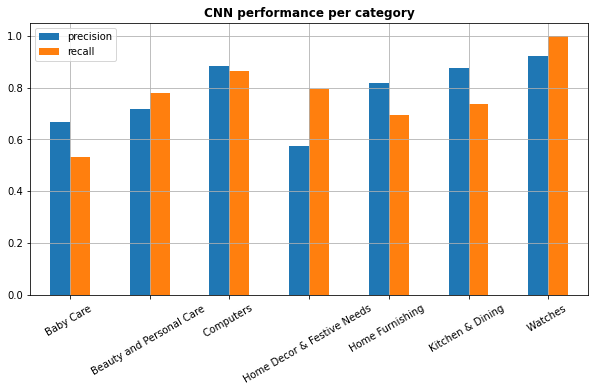

In [ ]:
# Plotting scores
report = classification_report(y_test_nb.values.argmax(axis = 1),
                               y_pred_nb.argmax(axis = 1),
                               output_dict = True)

df_report = pd.DataFrame(report).iloc[:2,:7]
df_report.columns = y_.columns

df_report.T.plot(kind = 'bar', figsize = (10,5), rot = 30)
plt.title('CNN performance per category', fontweight = 'bold')
plt.grid(True)
plt.show()

# CNN on RGB images

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

save_path = '/content/drive/My Drive/DS_projet6/Edited_Images_RGB300/'

# Creating image collection
for i in range(len(data)):
    img = load_img(save_path + data['image'][i], target_size=(300, 300))
    img = img_to_array(img)
    
    if i == 0:
        img_collec_rgb = img
    else:
        img_collec_rgb = np.append(img_collec_rgb, img)

img_collec_rgb = img_collec_rgb.reshape((len(data), 300, 300, 3))

In [ ]:
# Train - test split
from sklearn.model_selection import train_test_split
X_train_rgb, X_test_rgb, y_train_rgb, y_test_rgb = train_test_split(img_collec_rgb, y_, test_size = 0.35, random_state = 143)

In [ ]:
# Training model
new_model.fit(X_train_rgb, y_train_rgb, 
              batch_size = 100, 
              epochs = 30, 
              validation_split = 0.2)

Epoch 1/30
6/6 [==============================] - 5s 772ms/step - loss: 3.7609e-04 - accuracy: 1.0000 - val_loss: 4.1514 - val_accuracy: 0.8759
Epoch 2/30
6/6 [==============================] - 5s 767ms/step - loss: 6.1682e-08 - accuracy: 1.0000 - val_loss: 4.1246 - val_accuracy: 0.8759
Epoch 3/30
6/6 [==============================] - 5s 768ms/step - loss: 8.7272e-08 - accuracy: 1.0000 - val_loss: 4.1076 - val_accuracy: 0.8759
Epoch 4/30
6/6 [==============================] - 5s 773ms/step - loss: 9.6459e-08 - accuracy: 1.0000 - val_loss: 4.0977 - val_accuracy: 0.8759
Epoch 5/30
6/6 [==============================] - 5s 781ms/step - loss: 1.0740e-07 - accuracy: 1.0000 - val_loss: 4.0928 - val_accuracy: 0.8759
Epoch 6/30
6/6 [==============================] - 5s 778ms/step - loss: 1.0630e-07 - accuracy: 1.0000 - val_loss: 4.0901 - val_accuracy: 0.8759
Epoch 7/30
6/6 [==============================] - 5s 776ms/step - loss: 1.0411e-07 - accuracy: 1.0000 - val_loss: 4.0886 - val_accuracy:

In [ ]:
# Model performance
from sklearn.metrics import classification_report
y_pred_rgb = new_model.predict(X_test_rgb)

print(classification_report(y_test_rgb.values.argmax(axis = 1), y_pred_rgb.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.88      0.76      0.81        58
           1       0.79      0.90      0.84        51
           2       0.81      0.92      0.86        51
           3       0.76      0.90      0.82        52
           4       0.97      0.73      0.84        52
           5       0.91      0.87      0.89        47
           6       1.00      0.98      0.99        57

    accuracy                           0.87       368
   macro avg       0.88      0.87      0.87       368
weighted avg       0.88      0.87      0.87       368



In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(
    confusion_matrix(
        y_test_rgb.values.argmax(axis = 1),
        y_pred_rgb.argmax(axis=1)),
    index = y_.columns,
    columns = y_.columns)

,Baby Care,Beauty and Personal Care,Computers,Home Decor & Festive Needs,Home Furnishing,Kitchen & Dining,Watches
Baby Care,44,2,3,7,1,1,0
Beauty and Personal Care,0,46,2,1,0,2,0
Computers,0,2,47,2,0,0,0
Home Decor & Festive Needs,0,1,3,47,0,1,0
Home Furnishing,6,4,1,3,38,0,0
Kitchen & Dining,0,2,2,2,0,41,0
Watches,0,1,0,0,0,0,56


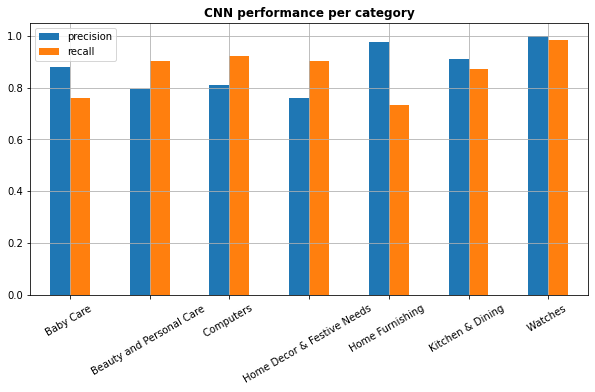

In [ ]:
# Plotting scores
report = classification_report(y_test_rgb.values.argmax(axis = 1),
                               y_pred_rgb.argmax(axis = 1),
                               output_dict = True)

df_report = pd.DataFrame(report).iloc[:2,:7]
df_report.columns = y_.columns

df_report.T.plot(kind = 'bar', figsize = (10,5), rot = 30)
plt.title('CNN performance per category', fontweight = 'bold')
plt.grid(True)
plt.show()

In [ ]:
# Creating a DataFrame containing probabilities to belong to a given category given an image
y_glob_rgb = new_model.predict(img_collec_rgb)

df_pred_img = pd.DataFrame(y_glob_rgb,
                           columns = ['p(C{}|image)'.format(x) for x in range(7)])

df_pred_img['img_prediction'] = y_glob_rgb.argmax(axis=1)
df_pred_img

,p(C0|image),p(C1|image),p(C2|image),p(C3|image),p(C4|image),p(C5|image),p(C6|image),img_prediction
0,1.258559e-33,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0,4
1,1.000000e+00,1.147650e-34,0.0,2.812893e-31,0.0,0.0,0.0,0
2,1.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0
3,2.218125e-21,9.046938e-31,0.0,1.868768e-36,1.0,0.0,0.0,4
4,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...
1045,1.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0
1046,1.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0
1047,1.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0
1048,1.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0


In [ ]:
df_pred_img.to_pickle('/content/drive/My Drive/DS_projet6/CNN_prediction.pkl')